# Constructing a Neural Network for Regression from Scratch

This notebook explains the process of constructing a neural network for regression to noisy data from scratch without using existing frameworks provided by libraries like PyTorch, Keras, and TensorFlow.

In [1418]:
import numpy as np
import matplotlib.pyplot as plt

Create some noisy synthetic data to test the neural network on. Each column of $X$ and $Y$ represents a data sample. Separate $X$ and $Y$ into training and testing data sets.

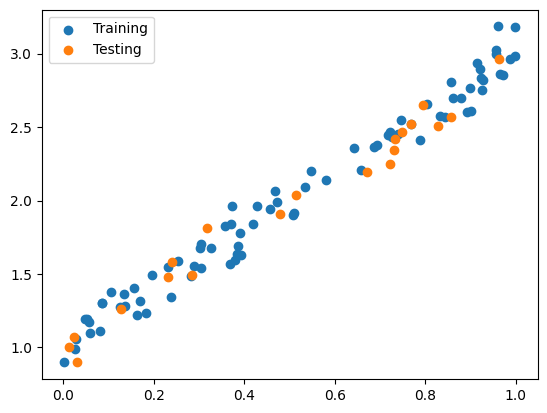

In [1419]:
X = np.random.rand(100)
X = np.reshape(X, (1, 100))
m0 = 2
b0 = 1
Y = m0*X + b0 + np.random.normal(0, 0.1, size=100)

X_train = X[:, :80]
Y_train = Y[:, :80]

X_test = X[:, 80:]
Y_test = Y[:, 80:]

plt.scatter(X_train, Y_train)
plt.scatter(X_test, Y_test)
plt.legend(["Training", "Testing"])
plt.show()

Initialise the neural network. Let $\sigma$ be a list with the activation function for each layer, $W$ be a list of the weights for each layer, and $b$ be a list of the biases for each layer. Use Xavier initialisation for the weights.

In [1420]:
layers = [1, 5, 5, 1]

sigma = [np.tanh, np.tanh, lambda x : x]
dsigma = [lambda x : np.cosh(x) ** (-2), lambda x : np.cosh(x) ** (-2), lambda x : 1] 

def initialise(layers):
    W = list()
    b = list()

    xavier_sigma = np.sqrt(2 / (layers[0] + layers[-1]))

    for i in range(0, len(layers) - 1):
        W.append(np.random.normal(0, xavier_sigma, size=(layers[i + 1], layers[i])))
        b.append(np.zeros((layers[i + 1], 1)))
    
    return W, b

W, b = initialise(layers)


Implement forward propagation of the inputs $X$ using matrix multiplication.

\begin{gather*}
    Z^{(1)} = W^{(1)}X + b^{(1)} \\
    Z^{(l)} = W^{(l)}A^{(l-1)} + b^{(l)} \\
    A^{(l)} = \tanh\left(Z^{(l)}\right)
\end{gather*}

In [1421]:
def fwd_prop(input):
    if len(input) == layers[0]:
        Z = [input]
        A = [input]
        
        Z_l = np.matmul(W[0], input) + b[0]
        A_l = sigma[0](Z_l)
        Z.append(Z_l)
        A.append(A_l)
        
        for i in range(1, len(layers) - 1):
            Z_l = np.matmul(W[i], A_l) + b[i]
            A_l = sigma[i](Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        return A, Z
          
    else:
        raise Exception("Input does not have valid dimensions")

def evaluate(input):
    A, Z = fwd_prop(input)
    return A[-1]

Let $Y$ be the targets and $A^{(L)}$ be the predictions. Assume $Y$ and $A^{(L)}$ are $n \times m$ matrices, meaning that there are $n$ outputs and $m$ training samples

Use a quadratic cost function $C_j$ for the $j$-th training sample ($Y_j$ is the target vector and $A^{(L)}_j$ is the prediction vector).

$$C_j = \frac{1}{2n} \sum_{i=1}^n (Y_{i,j} - A^{(L)}_{i,j})^2$$

The cost function $C$ for all training samples is

$$C = \frac{1}{m} \sum_{j=1}^m C_j$$

In [1422]:
def cost_v1(A_L, Y):
    if A_L.shape == Y.shape:
        return np.linalg.norm(np.array(A_L) - np.array(Y))**2 / (2 * Y.size)
    else:
        raise Exception("Prediction and target matrices must have the same shape")

To optimise the weights and biases, it is necessary to compute the derivatives of the cost function with respect to each weight and bias. This is done using backpropagation.

Consider the $i$-th training sample. Let the error in the output layer be $\delta^{(L)}$. Its components are given by
$$\delta^{(L)}_j = \frac{\partial C_i}{\partial a^{(L)}_j} \sigma'(z_j^{(L)})$$
where $a$ refers to the activated neurons, $z$ refers to the unactivated neurons, and $\sigma$ is the activation function.

This can be computed using
$$\delta^{(L)} = \nabla_a C_i \odot \sigma'(z^{(L)})$$
where $\nabla_a C_i$ is a vector whose components are the partial derivatives $\partial C_i / \partial a^{(L)}_j$ and $\odot$ is the Hadamard (elementwise) product.

For the quadratic cost function,
$$\nabla_a C_i = \frac{1}{n} (a^{(L)} - y)$$

Then, the error in a hidden layer can be calculated using the error in the subsequent layer using
$$\delta^{(l)} = \left((W^{(l+1)})^T \delta^{(l+1)}\right) \odot \sigma'(z^{(l)})$$

Once the errors in each layer (except the input layer) have been computed, the partial derivatives of the cost function for the $i$-th training sample with respect to the weights and biases can be computed using
\begin{gather*}
    \frac{\partial C_i}{\partial b^{(l)}_j} = \delta^{(l)}_j \\
    \frac{\partial C_i}{\partial W^{(l)}_{j,k}} = a^{(l-1)}_k \delta^{(l)}_j
\end{gather*}

It follows that the partial derivatives of the overall cost function are
\begin{gather*}
    \frac{\partial C}{\partial b^{(l)}_j} = \sum_{i=1}^m \frac{\partial C_i}{\partial b^{(l)}_j} \\
    \frac{\partial C}{\partial W^{(l)}_{j,k}} = \sum_{i=1}^m \frac{\partial C_i}{\partial W^{(l)}_{j,k}}
\end{gather*}

Refer to [Neural Networks and Deep Learning, chapter 2](http://neuralnetworksanddeeplearning.com/chap2.html) for details, including proofs.

In [1423]:
def grad_cost_v1(A_L, Y):
    if A_L.shape == Y.shape:
        return (A_L - Y) / (Y.size)
    else:
        raise Exception("A_L and Y must have the same dimensions")

In [1424]:
def back_prop(A, Z, Y, grad_cost):
    delta = list()
    
    delta_l = np.multiply(grad_cost(A[-1], Y), dsigma[-1](Z[-1]))
    delta = [delta_l] + delta

    for l in range(len(layers) - 3, -1, -1):
        delta_l = np.multiply(np.matmul(W[l+1].T, delta_l), dsigma[l](Z[l]))
        delta = [delta_l] + delta

    dC_db = list()
    dC_dW = list()
    
    for l in range(0, len(delta)):
        dC_db_l = np.sum(delta[l], axis=1, keepdims=True)
        dC_db.append(dC_db_l)

        dC_dW_l = np.zeros(W[l].shape)

        for i in range(0, delta[l].shape[1]):
            dC_dW_l += np.outer(delta[l][:, i], A[l][:, i])
        
        dC_dW.append(dC_dW_l)
    
    return dC_db, dC_dW
    

To train the neural network, use gradient descent. This requires the weights and biases to be updated by subtracting $\eta \nabla_W C$ and $\eta \nabla_b C$ respectively, where $\eta$ is the learning rate.

In [1425]:
def train(X_train, Y_train, X_test, Y_test, cost, grad_cost, eta, epochs):
    costs_train = np.empty(epochs)
    costs_test = np.empty(epochs)
    
    for i in range(1, epochs + 1):
        A, Z = fwd_prop(X_train)
        dC_db, dC_dW = back_prop(A, Z, Y_train, grad_cost)
        
        if len(W) == len(dC_dW):
            for l in range(0, len(W)):
                W[l] -= eta * dC_dW[l]
        else:
            raise Exception("W and dC_dW must have the same length")
        
        if len(b) == len(dC_db):
            for l in range(0, len(b)):
                b[l] -= eta * dC_db[l]
        else:
            raise Exception("b and dC_db must have the same length")

        costs_train[i - 1] = cost(A[-1], Y_train)
        costs_test[i - 1] = cost(evaluate(X_test), Y_test)
    
    plt.plot(np.linspace(1, epochs, epochs), costs_train)
    plt.plot(np.linspace(1, epochs, epochs), costs_test)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.yscale("log")
    plt.legend(["Training", "Testing"])
    plt.show()

Train the neural network for 2000 epochs and plot the cost.

From empirical observations, it seems that exploding gradients occur when $\eta < 0.4$. The neural network converges quite quickly and reliably when $\eta = 0.1$

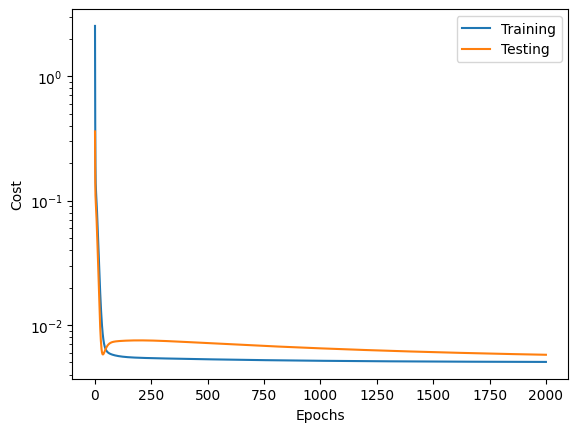

In [1426]:
eta = 0.1

train(X_train, Y_train, X_test, Y_test, cost_v1, grad_cost_v1, eta, 2000)

Plot the predictions against the training and testing data.

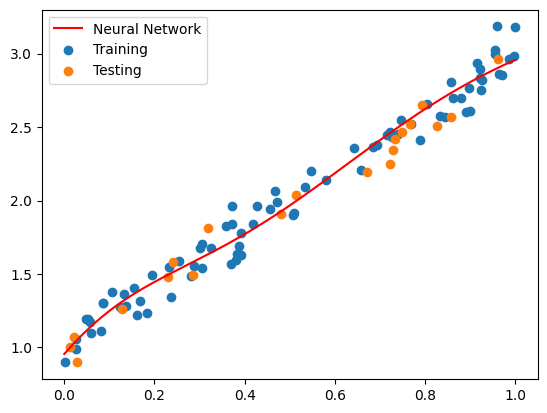

: 

In [1427]:
x_verification = np.linspace(0, 1, 501)
x_verification = np.reshape(x_verification, (1, 501))
A, Z = fwd_prop(x_verification)
y_verification = A[-1]

x_verification = np.squeeze(x_verification)
y_verification = np.squeeze(y_verification)

plt.plot(np.array(x_verification), np.array(y_verification), 'r')
plt.scatter(X_train, Y_train)
plt.scatter(X_test, Y_test)
plt.legend(["Neural Network", "Training", "Testing"])
plt.show()

The neural network is able to perform regression quite well, apart from the fact that the solutions occasionally have noticeable nonlinearities. Sometimes, the solution is very poor; this is likely due to the neural network converging to a local minimum - an unavoidable limitation of the gradient descent algorithm.

The neural network doesn't seem to overfit to the training data. This is likely due to the noisy nature of the data samples.